## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
train_data = prostate.drop("train", axis=1)[prostate["train"] == "T"]
test_data = prostate.drop("train", axis=1)[prostate["train"] == "F"]

scaler = StandardScaler()
scaler.fit(train_data)
train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.transform(test_data)
X_train = train_data_std[:, :-1]
y_train = train_data_std[:, -1]
X_test = test_data_std[:, :-1]
y_test = test_data_std[:, -1]

## The Lasso

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class LASSO(BaseEstimator, RegressorMixin):
    """
    LASSO
    使用最小角度回归算法
    参数：
    -----
    normalized: 是否标准化输入矩阵
    
    属性：
    -----
    Beta: 系数
    beta_path: 系数路径
    activte_set: 记录依次添加特征的顺序集合
    """
    def __init__(self, alpha, normalized=False):
        self.alpha = alpha
        self.normalized = normalized
    
    def fit(self, X, y):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        X = np.c_[np.ones(len(X)), X]
        n, p = X.shape
        cur_pred = y.mean()
        residual = y - cur_pred
        cur_corr = X.T @ residual  # 使用内积代替相关性度量
        j = np.argmax(np.abs(cur_corr), axis=0)  #返回有最大相关度变量的索引
        self.active_set = [j]  # 将有最大相关度变量的索引保存在活跃集9中
        beta = np.zeros(p)  
        sign = np.zeros(p)  # 标记活跃变量
        sign[j] = 1

        self.beta_path = np.zeros((p, p))  # 存储系数路径
        self.beta_path[0] = beta
        tol = 1e-5
        for it in range(p):
            residual = y - cur_pred
            corrs = X.T @ residual # 计算各个特征与残差之间的相关度

            X_a = X[:, self.active_set]
            X_a *= sign[self.active_set]

            G_a_inv = np.linalg.inv(X_a.T @ X_a)

            G_a_inv_red_cols = np.sum(G_a_inv, 1)
            A_a = 1 / np.sqrt(np.sum(G_a_inv_red_cols))
            omega = A_a * G_a_inv_red_cols
            equiangular = X_a @ omega 

            cos_angle = X.T @ equiangular # 用内积表示相关性
            gamma = None
            largest_abs_correlation = np.abs(corrs).max()
            if it < p - 1:
                next_j = None
                next_sign = 0
                for j in range(p):
                    if j in self.active_set:
                        continue
                    v0 = (largest_abs_correlation - corrs[j]) / (A_a - cos_angle[j]).item()
                    v1 = (largest_abs_correlation + corrs[j]) / (A_a + cos_angle[j]).item()
                    if v0 > 0 and (gamma is None or v0 < gamma):
                        next_j = j
                        gamma = v0
                        next_sign = 1
                    if v1 > 0 and (gamma is None or v1 < gamma):
                        gamma = v1
                        next_j = j
                        next_sign = -1
            else:
                gamma = largest_abs_correlation / A_a

            sa = X_a
            sb = equiangular * gamma
            sx = np.linalg.lstsq(sa, sb)  # 更新方向
#             print(self.active_set)
            for i, j in enumerate(self.active_set):
                beta[j] += self.alpha * sx[0][i] * sign[j] # 更新系数，向各自的最小二乘系数移动
                if beta[j] < tol:
                    self.active_set.remove(j)

            cur_pred = X @ beta
            sign[next_j] = next_sign
            self.active_set.append(next_j)
            if it < p -1:
                self.beta_path[it+1, :] = beta # 将更新后的系数加入系数路径中
                
        self.Beta = self.beta_path[-1]
        self.active_set = self.active_set[:-2] - np.ones(len(self.active_set[:-2]))

        return self    

    def predict(self, X):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        X = np.c_[np.ones(len(X)), X]
        y_pred = X @ self.Beta
        return y_pred

In [16]:
lar = LASSO(alpha=0.2)
lar.fit(X_train, y_train)

E:\a-soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


LASSO(alpha=0.2, normalized=False)

In [17]:
y_train_preds = lar.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.367


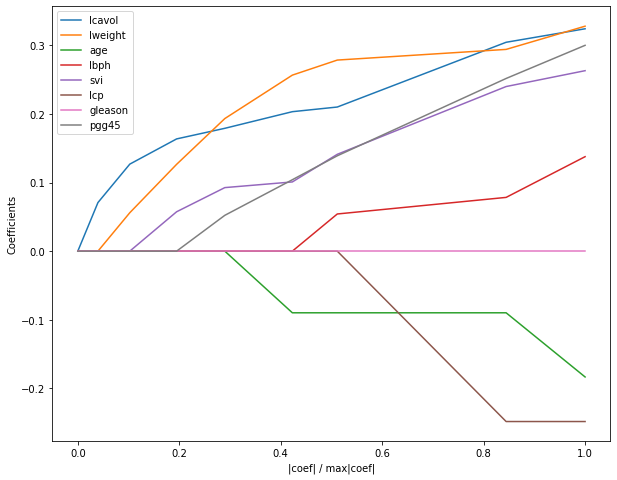

In [18]:
coef_path = lar.beta_path.T
xx = np.sum(np.abs(coef_path.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10, 8))
p = X_train.shape[1]
for i in range(p):
    plt.plot(xx, coef_path[i+1, :], label=list(train_data.columns)[i])
plt.legend()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.show()

## 使用`Sklearn`

In [47]:
from sklearn.linear_model import LassoLars

In [60]:
sk_lar = LassoLars(alpha=0.01)
sk_lar.fit(X_train, y_train)

LassoLars(alpha=0.01, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
          positive=False, precompute='auto', verbose=False)

In [61]:
y_train_pred = sk_lar.predict(X_train)
train_err = mean_squared_error(y_train, y_train_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.351


In [62]:
y_test_pred = sk_lar.predict(X_test)
test_err = mean_squared_error(y_test, y_test_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.315


### 寻找最优L1正则化参数

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoLarsCV

In [55]:
lar_cv = LassoLarsCV(cv=10)
lar_cv.fit(X_train, y_train)

LassoLarsCV(copy_X=True, cv=10, eps=2.220446049250313e-16, fit_intercept=True,
            max_iter=500, max_n_alphas=1000, n_jobs=None, normalize=True,
            positive=False, precompute='auto', verbose=False)

In [61]:
y_train_preds = lar_cv.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [62]:
y_test_pred = lar_cv.predict(X_test)
test_err = mean_squared_error(y_test, y_test_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.353


In [103]:
print("最优的L1正则化参数：{}".format(lar_cv.alpha_))

最优的L1正则化参数：0.0005142622158586602


### LASSO路径

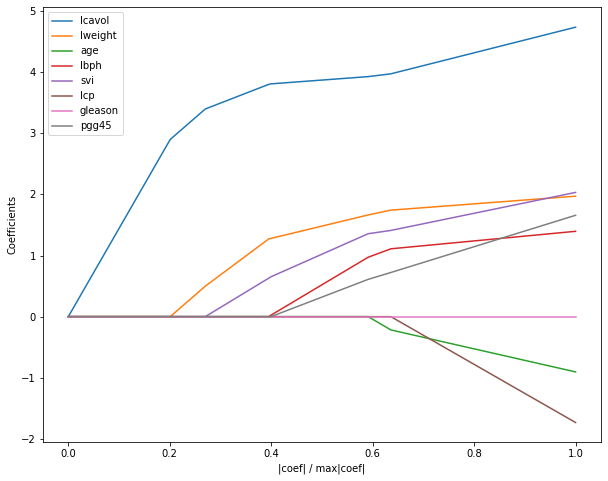

In [78]:
# vs 
coef_path = lar_cv.coef_path_
xx = np.sum(np.abs(coef_path.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10, 8))
p = X_train.shape[1]
for i in range(p):
    plt.plot(xx, coef_path[i, :], label=list(train_data.columns)[i])
plt.legend()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.show()

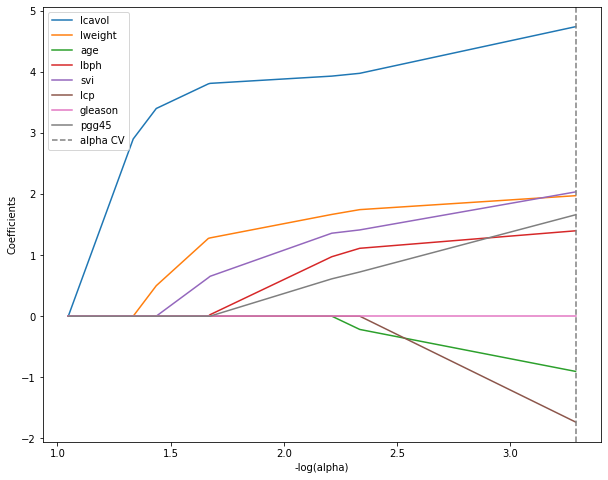

In [82]:
# 正则化路径
log_alphas = -np.log10(lar_cv.alphas_)
plt.figure(figsize=(10, 8))
for i in range(p):
    plt.plot(log_alphas, coef_path[i, :], label=list(train_data.columns)[i])
plt.axvline(-np.log10(lar_cv.alpha_), linestyle='--', 
            color='gray', label='alpha CV')
plt.xlabel("-log(alpha)")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

### 误差曲线

E:\a-soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


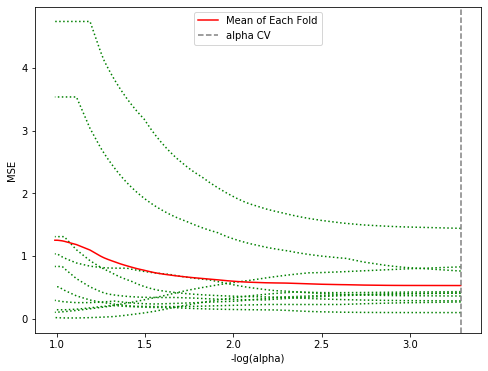

In [99]:
log_alphascv = -np.log10(lar_cv.cv_alphas_)

plt.figure(figsize=(8, 6))
plt.plot(log_alphascv, lar_cv.mse_path_, linestyle=':', c='g')
plt.plot(log_alphascv, lar_cv.mse_path_.mean(axis=1), c='r', 
         label='Mean of Each Fold')
plt.axvline(-np.log10(lar_cv.alpha_), linestyle='--', 
            color='gray', label='alpha CV')
plt.legend()
plt.xlabel("-log(alpha)")
plt.ylabel("MSE")
plt.show()

In [67]:
pd.options.display.float_format = '{:.3f}'.format
variables = ["Intercept"] + list(train_data.iloc[:, :-1].columns)
pd.DataFrame({"系数": variables, 
              "值": np.r_[train_data.iloc[:, -1].mean(), 
                                   lar_cv.coef_]})

,系数,值
0,Intercept,2.452
1,lcavol,0.579
2,lweight,0.241
3,age,-0.110
4,lbph,0.171
5,svi,0.248
6,lcp,-0.212
7,gleason,0.000
8,pgg45,0.203
